In [34]:
from scipy.special import expit
import torch.nn as nn
import torch
from torch.autograd import Variable 
import pprint
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# from sklearn.metrics import mean_absolute_percentage_error
def mean_absolute_percentage_error(y_true, y_pred): 
    # y_true, y_pred = check_arrays(y_true, y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
pp = pprint.PrettyPrinter(indent=4)
torch.set_printoptions(precision=10)
torch.backends.cudnn.enabled = False

In [35]:
target = 'X30cm'
tau_hours = 24
tau = tau_hours * 3   # sub-sampling period = 20 minutes. 3 samples per hour. 


In [36]:
X_train = np.random.rand(200, 5)
X_test = np.random.rand(53, 5)
y_train = np.random.rand(200, 1)
y_test = np.random.rand(53, 1)
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 


Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [37]:
data_path = '/home/anir/pit1.smooth.csv'
# data_path = '/data/users/anir/pit1.smooth.csv'
pit1_smooth = pd.read_csv(data_path)
pit1_smooth

,Unnamed: 0,X,date,X5cm,X15cm,X30cm,rainfall
0,1,1,2007-12-01 13:48:00,0.040442,0.078520,0.037802,0.0
1,2,2,2007-12-01 13:50:00,0.040425,0.078521,0.037801,0.0
2,3,3,2007-12-01 13:52:00,0.040408,0.078523,0.037799,0.0
3,4,4,2007-12-01 13:54:00,0.040392,0.078524,0.037798,0.0
4,5,5,2007-12-01 13:56:00,0.040375,0.078525,0.037796,0.0
...,...,...,...,...,...,...,...
133543,133552,133770,2008-09-05 03:48:00,-0.050170,0.048757,0.051869,0.0
133544,133553,133771,2008-09-05 03:54:00,-0.050168,0.048760,0.051873,0.0
133545,133554,133772,2008-09-05 04:00:00,-0.050166,0.048764,0.051876,0.0
133546,133555,133773,2008-09-05 04:06:00,-0.050165,0.048767,0.051880,0.0


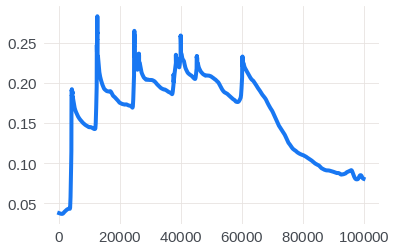

In [38]:
pit1_smooth = pit1_smooth.iloc[1:100000, ]
pit1_smooth['X30cm'].plot()

In [39]:
raw_data_rows = pit1_smooth.shape[0]
pit1_smooth_sampled = pit1_smooth.iloc[0:raw_data_rows:10].reset_index()
sampled_data_rows = pit1_smooth_sampled.shape[0]
pit1_smooth_sampled.head(10)

,index,Unnamed: 0,X,date,X5cm,X15cm,X30cm,rainfall
0,1,2,2,2007-12-01 13:50:00,0.040425,0.078521,0.037801,0.0
1,11,12,12,2007-12-01 14:10:00,0.040258,0.078532,0.037785,0.0
2,21,22,22,2007-12-01 14:30:00,0.040092,0.078544,0.037769,0.0
3,31,32,32,2007-12-01 14:50:00,0.039925,0.078555,0.037753,0.0
4,41,42,42,2007-12-01 15:10:00,0.039758,0.078566,0.037737,0.0
5,51,52,52,2007-12-01 15:30:00,0.039591,0.078577,0.037721,0.0
6,61,62,62,2007-12-01 15:50:00,0.039425,0.078588,0.037705,0.0
7,71,72,72,2007-12-01 16:10:00,0.039258,0.078599,0.037689,0.0
8,81,82,82,2007-12-01 16:30:00,0.039091,0.078610,0.037674,0.0
9,91,92,92,2007-12-01 16:50:00,0.038925,0.078621,0.037658,0.0


In [41]:
# Create time shifted dataset

features = ['I_0']
pit1_smooth_sampled['I_0'] = pit1_smooth_sampled['rainfall']
for i in range(1, tau + 1):
    shifted_moisture_column = 'M_%d' % i
    pit1_smooth_sampled[shifted_moisture_column] = pit1_smooth_sampled[target].shift(i, fill_value=0)
    shifted_rainfall_column = 'I_%d' % i
    pit1_smooth_sampled[shifted_rainfall_column] = pit1_smooth_sampled['rainfall'].shift(i, fill_value=0)
    features.append(shifted_moisture_column)
    features.append(shifted_rainfall_column)

pit1_smooth_sampled.head(20)

,index,Unnamed: 0,X,date,X5cm,X15cm,X30cm,rainfall,I_0,M_1,I_1,M_2,I_2,M_3,I_3,M_4,I_4,M_5,I_5,M_6,I_6,M_7,I_7,M_8,I_8,M_9,I_9,M_10,I_10,M_11,I_11,M_12,I_12,M_13,I_13,M_14,I_14,M_15,I_15,M_16,...,M_53,I_53,M_54,I_54,M_55,I_55,M_56,I_56,M_57,I_57,M_58,I_58,M_59,I_59,M_60,I_60,M_61,I_61,M_62,I_62,M_63,I_63,M_64,I_64,M_65,I_65,M_66,I_66,M_67,I_67,M_68,I_68,M_69,I_69,M_70,I_70,M_71,I_71,M_72,I_72
0,1,2,2,2007-12-01 13:50:00,0.040425,0.078521,0.037801,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,11,12,12,2007-12-01 14:10:00,0.040258,0.078532,0.037785,0.0,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,21,22,22,2007-12-01 14:30:00,0.040092,0.078544,0.037769,0.0,0.0,0.037785,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,31,32,32,2007-12-01 14:50:00,0.039925,0.078555,0.037753,0.0,0.0,0.037769,0.0,0.037785,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,41,42,42,2007-12-01 15:10:00,0.039758,0.078566,0.037737,0.0,0.0,0.037753,0.0,0.037769,0.0,0.037785,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,51,52,52,2007-12-01 15:30:00,0.039591,0.078577,0.037721,0.0,0.0,0.037737,0.0,0.037753,0.0,0.037769,0.0,0.037785,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,61,62,62,2007-12-01 15:50:00,0.039425,0.078588,0.037705,0.0,0.0,0.037721,0.0,0.037737,0.0,0.037753,0.0,0.037769,0.0,0.037785,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,71,72,72,2007-12-01 16:10:00,0.039258,0.078599,0.037689,0.0,0.0,0.037705,0.0,0.037721,0.0,0.037737,0.0,0.037753,0.0,0.037769,0.0,0.037785,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,81,82,82,2007-12-01 16:30:00,0.039091,0.078610,0.037674,0.0,0.0,0.037689,0.0,0.037705,0.0,0.037721,0.0,0.037737,0.0,0.037753,0.0,0.03

In [42]:
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(pit1_smooth_sampled[features])
y_mm = mm.fit_transform(pit1_smooth_sampled[target].values.reshape(-1, 1)) 

In [43]:
train_end = 2200  # 3000
X_train = X_ss[:train_end,]
X_test = X_ss[train_end+1 : ,]
y_train = y_mm[:train_end,]
y_test = y_mm[train_end+1:,]
print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 


Training Shape (2200, 145) (2200, 1)
Testing Shape (7799, 145) (7799, 1)


In [44]:
pit1_smooth_sampled

,index,Unnamed: 0,X,date,X5cm,X15cm,X30cm,rainfall,I_0,M_1,I_1,M_2,I_2,M_3,I_3,M_4,I_4,M_5,I_5,M_6,I_6,M_7,I_7,M_8,I_8,M_9,I_9,M_10,I_10,M_11,I_11,M_12,I_12,M_13,I_13,M_14,I_14,M_15,I_15,M_16,...,M_53,I_53,M_54,I_54,M_55,I_55,M_56,I_56,M_57,I_57,M_58,I_58,M_59,I_59,M_60,I_60,M_61,I_61,M_62,I_62,M_63,I_63,M_64,I_64,M_65,I_65,M_66,I_66,M_67,I_67,M_68,I_68,M_69,I_69,M_70,I_70,M_71,I_71,M_72,I_72
0,1,2,2,2007-12-01 13:50:00,0.040425,0.078521,0.037801,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,11,12,12,2007-12-01 14:10:00,0.040258,0.078532,0.037785,0.0,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
2,21,22,22,2007-12-01 14:30:00,0.040092,0.078544,0.037769,0.0,0.0,0.037785,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
3,31,32,32,2007-12-01 14:50:00,0.039925,0.078555,0.037753,0.0,0.0,0.037769,0.0,0.037785,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,41,42,42,2007-12-01 15:10:00,0.039758,0.078566,0.037737,0.0,0.0,0.037753,0.0,0.037769,0.0,0.037785,0.0,0.037801,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,99951,99952,99952,2008-05-02 10:18:00,-0.040691,0.082835,0.080614,0.0,0.0,0.080634,0.0,0.080654,0.0,0.080674,0.0,0.080694,0.0,0.080713,0.0,0.080733,0.0,0.080753,0.0,0.080773,0.0,0.080793,0.0,0.080813,0.0,0.080838,0.0,0.080878,0.0,0.080918,0.0,0.080958,0.0,0.080998,0.0,0.081038,...,0.083590,0.0,0.083668,0.0,0.083736,0.0,0.083799,0.0,0.083863,0.0,0.083926,0.0,0.083990,0.0,0.084053,0.0,0.084117,0.0,0.084180,0.0,0.084243,0.0,0.084307,0.0,0.084370,0.0,0.084416,0.0,0.084457,0.0,0.084498,0.0,0.084539,0.0,0.084581,0.0,0.084622,0.0,0.084663,0.0
9996,99961,99962,99962,2008-05-02 11:18:00,-0.040698,0.082807,

In [45]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([2200, 1, 145]) torch.Size([2200, 1])
Testing Shape torch.Size([7799, 1, 145]) torch.Size([7799, 1])


In [46]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # number of classes
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
        

In [47]:
tau_hours = 24
tau = tau_hours * 3 
features = ['M_%d' % tau]
for i in range(0, tau + 1):
    features += ['I_%d' % i]
X_ss = ss.fit_transform(pit1_smooth_sampled[features])
y_mm = mm.fit_transform(pit1_smooth_sampled[target].values.reshape(-1, 1))     
train_end = 2200  # 3000
X_train = X_ss[:train_end,]
X_test = X_ss[train_end+1 : ,]
y_train = y_mm[:train_end,]
y_test = y_mm[train_end+1:,]    

X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 


In [48]:
num_epochs = 4000  # 1000 epochs
learning_rate = 0.001  # 0.001 lr

input_size = len(features) # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = 1 # number of output classes 
lstm_sm_rain = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) 
print(tau_hours, input_size)
print(lstm_sm_rain)


24 74
LSTM(
  (lstm): LSTM(74, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


Epoch: 0, loss: 0.18782


Epoch: 500, loss: 0.00178


Epoch: 1000, loss: 0.00140


Epoch: 1500, loss: 0.00118


Epoch: 2000, loss: 0.00101


Epoch: 2500, loss: 0.00095


Epoch: 3000, loss: 0.00092


Epoch: 3500, loss: 0.00090


End training


Text(0.5, 1.0, 'Test data')

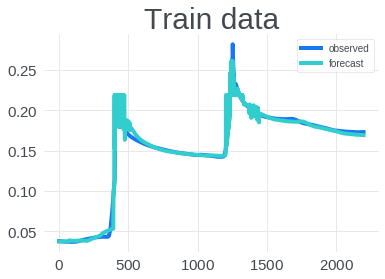

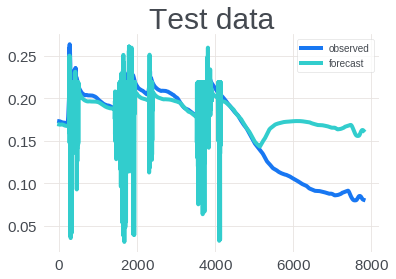

In [49]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_sm_rain.parameters(), lr=learning_rate) 
for epoch in range(num_epochs):
  outputs = lstm_sm_rain.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 500 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

print('End training')

train_predict = lstm_sm_rain(X_train_tensors_final)  # forward pass
data_predict = train_predict.data.numpy()  # numpy conversion
pd.DataFrame({'observed': mm.inverse_transform(y_train).flatten(), 
    'forecast': mm.inverse_transform(data_predict).flatten()}).plot()
plt.title('Train data')

test_predict = lstm_sm_rain(X_test_tensors_final)  # forward pass
data_predict = test_predict.data.numpy()  # numpy conversion
pd.DataFrame({'observed': mm.inverse_transform(y_test).flatten(), 
    'forecast': mm.inverse_transform(data_predict).flatten()}).plot()
plt.title('Test data')


Generate error vs $\tau$ curves

In [50]:
train_predict = lstm_sm_rain(X_train_tensors_final)  # forward pass
data_predict = train_predict.data.numpy()  # numpy conversion
train_obs = mm.inverse_transform(y_train).flatten()
train_pred = mm.inverse_transform(data_predict).flatten()

test_predict = lstm_sm_rain(X_test_tensors_final)  # forward pass
data_predict = test_predict.data.numpy()  # numpy conversion
test_obs = mm.inverse_transform(y_test).flatten()
test_pred = mm.inverse_transform(data_predict).flatten()


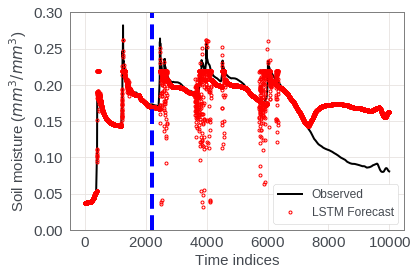

In [51]:

axes = pd.DataFrame({'Observed': np.append(train_obs, test_obs),
'LSTM Forecast': np.append(train_pred, test_pred)}).plot(style=['k-', 'ro'], fillstyle='none', markersize=3, linewidth=2)
axes.set_ylim([0.0, 0.3])
train_end
plt.plot([train_end, train_end], [0, 0.3], 'b--')
axes.set_xlabel('Time indices')
axes.set_ylabel('Soil moisture ' + r'($mm^3 / mm^3$)')
legend=axes.legend(loc='lower right', prop={'size': 12}, fancybox=True, framealpha=1)
# legend.get_frame().set_alpha(None)
# legend.get_frame().set_facecolor((0, 0, 1, 0.1))

color_name = "grey"
axes.spines["top"].set_color(color_name)
axes.spines["bottom"].set_color(color_name)
axes.spines["left"].set_color(color_name)
axes.spines["right"].set_color(color_name)
plt.savefig('lstm_forecast_30_cm_regular.eps', format='eps', bbox_inches="tight", edgecolor='k')


In [52]:
def generate_error_for_tau(tau_hours, num_epochs=2000, hidden_size = 2, num_layers = 1):
    target = 'X30cm'
    # tau_hours = 2
    tau = tau_hours * 3 
    features = ['M_%d' % tau]
    for i in range(0, tau + 1):
        features += ['I_%d' % i]
    max_min_scaler = MinMaxScaler()
    standard_scaler = StandardScaler()

    X_ss = standard_scaler.fit_transform(pit1_smooth_sampled[features])
    y_mm = max_min_scaler.fit_transform(pit1_smooth_sampled[target].values.reshape(-1, 1))     
    train_end = 2200  # 3000
    X_train = X_ss[:train_end,]
    X_test = X_ss[train_end+1 : ,]
    y_train = y_mm[:train_end,]
    y_test = y_mm[train_end+1:,]
    X_train_tensors = Variable(torch.Tensor(X_train))
    X_test_tensors = Variable(torch.Tensor(X_test))

    y_train_tensors = Variable(torch.Tensor(y_train))
    y_test_tensors = Variable(torch.Tensor(y_test)) 
    # reshaping to rows, timestamps, features
    X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
    X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

    input_size = len(features)
    lstm_sm_rain = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) 
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    optimizer = torch.optim.Adam(lstm_sm_rain.parameters(), lr=learning_rate) 
    for epoch in range(num_epochs):
        outputs = lstm_sm_rain.forward(X_train_tensors_final) # forward pass
        optimizer.zero_grad() # caluclate the gradient, manually setting to 0
        # obtain the loss function
        loss = criterion(outputs, y_train_tensors)
        loss.backward() # calculates the loss of the loss function
        optimizer.step()
    test_predict = lstm_sm_rain(X_test_tensors_final)  # forward pass
    data_predict = test_predict.data.numpy()  # numpy conversion
    test_observed = max_min_scaler.inverse_transform(y_test).flatten()
    test_forecast = max_min_scaler.inverse_transform(data_predict).flatten()
    delta = test_observed - test_forecast
    mse, max_error = np.mean(np.power(delta, 2)), max(abs(delta))
    mape = mean_absolute_percentage_error(test_observed, test_forecast)
    # print(tau_hours, mse, max_error)
    return [mse, max_error, mape]

In [53]:
for hidden_size in [2, 4, 8, 16]:
    tau_hour_values = np.array([1, 5, 10, 15, 20, 24])
    # tau_hour_values = np.array([1, 5])
    standard_errors=[]
    max_errors=[]
    mapes=[]
    for i, tau_hours in enumerate(tau_hour_values):
        mse, max_error, mape = generate_error_for_tau(tau_hours, num_epochs=4000, hidden_size = hidden_size)
        standard_errors.append(mse)
        max_errors.append(max_error)
        mapes.append(mape)
    error_df = pd.DataFrame({'tau': tau_hour_values, 'Standard error': standard_errors, 'Maximum error': max_errors, 'MAPE': mapes})
    print('LSTM', hidden_size)
    print(error_df)
    print('\n')

LSTM 2
   tau  Standard error  Maximum error       MAPE
0    1        0.000011       0.023837   1.762619
1    5        0.000959       0.115694  18.953250
2   10        0.000096       0.134997   2.462842
3   15        0.001139       0.206042  11.392739
4   20        0.000369       0.358078   3.808020
5   24        0.000915       0.204608   9.807148




LSTM 4
   tau  Standard error  Maximum error       MAPE
0    1        0.000111       0.069667   6.012867
1    5        0.001314       0.280332  20.977804
2   10        0.000141       0.189697   2.494611
3   15        0.000268       0.140804   8.655242
4   20        0.000239       0.148118   6.512257
5   24        0.000206       0.144159   6.251414




LSTM 8
   tau  Standard error  Maximum error       MAPE
0    1        0.000077       0.104511   4.717971
1    5        0.000599       0.236586  14.540823
2   10        0.000448       0.178078  11.482471
3   15        0.000413       0.172123  12.085069
4   20        0.000468       0.223788  12.460161
5   24        0.000590       0.151143  13.945687




LSTM 16
   tau  Standard error  Maximum error       MAPE
0    1        0.000059       0.118389   3.113038
1    5        0.000416       0.131808  11.678737
2   10        0.001076       0.194363  20.310670
3   15        0.000647       0.140765  15.204794
4   20        0.000575       0.210896  11.993338
5   24        0.000769       0.145266  17.366051




W0127 194740.526 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


W0127 194740.527 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


W0127 194740.712 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


W0127 194740.713 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


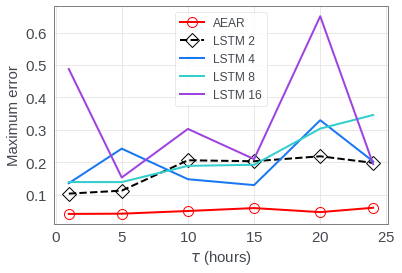

In [54]:
tau_hour_values = np.array([1, 5, 10, 15, 20, 24])
maxe = pd.DataFrame({'tau': tau_hour_values,
    'AEAR': [0.041, 0.0417, 0.05, 0.059, 0.0465, 0.06], 
    # 'LSTM': [0.05516988, 0.21529814, 0.21161827, 0.20113165, 0.20091764, 0.19155197],
    # 'LSTM': [0.15813034, 0.21150551, 0.16215832, 0.19104969, 0.21020297, 0.11649913],
    'LSTM 2': [0.103518, 0.112669, 0.206274, 0.203262, 0.218565, 0.198298, ],
    'LSTM 4': [0.135572,0.242094,0.147954,0.12976,0.329743,0.202737,],
    'LSTM 8': [0.139152,0.139022,0.189078,0.192445,0.303853,0.345829,],
    'LSTM 16': [0.487446,0.153176,0.302869,0.209887,0.650103,0.194523,],
    })
axes = maxe.plot(x='tau', style=['ro-', 'kD--'], fillstyle='none', markersize=10, linewidth=2)
# axes.set_ylim([0.02, 0.5])
axes.set_ylabel('Maximum error')
axes.set_xlabel(r'$\tau$' + ' (hours)')
# axes.legend(loc='center left', prop={'size': 16})
axes.legend(prop={'size': 12})

color_name = "grey"
axes.spines["top"].set_color(color_name)
axes.spines["bottom"].set_color(color_name)
axes.spines["left"].set_color(color_name)
axes.spines["right"].set_color(color_name)

plt.savefig('maximum_error_tau_aear_lstm.eps', format='eps', bbox_inches="tight", edgecolor='k')


In [55]:
error_df['Maximum error'].values

array([0.11838928, 0.13180843, 0.19436289, 0.14076476, 0.21089593,
       0.14526558])

W0127 194741.773 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


W0127 194741.774 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


W0127 194741.970 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


W0127 194741.971 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


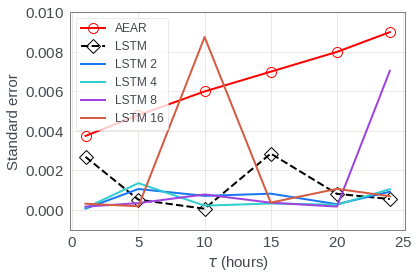

In [56]:
maxe = pd.DataFrame({'tau': tau_hour_values,
    'AEAR': [0.00375, 0.0048, 0.006, 0.007, 0.008, 0.009], 
    'LSTM': [2.69135409e-03, 5.22110293e-04, 6.67167967e-05, 2.85736975e-03, 8.18492912e-04, 5.57295839e-04],
    'LSTM 2': [0.000071, 0.001064, 0.000717, 0.000827, 0.000296, 0.000926,],
    'LSTM 4': [0.000109, 0.001359, 0.000222, 0.000331, 0.000268, 0.001054,],
    'LSTM 8': [0.000171, 0.000351, 0.000789, 0.000371, 0.000175, 0.007044,],
    'LSTM 16': [0.000319, 0.000191, 0.008752, 0.000376, 0.001071, 0.000699],
    })
axes = maxe.plot(x='tau', style=['ro-', 'kD--'], fillstyle='none', markersize=10, linewidth=2)
axes.set_ylim([-0.001, 0.01])
axes.set_ylabel('Standard error')
axes.set_xlabel(r'$\tau$' + ' (hours)')
# axes.legend(loc='center right', prop={'size': 16})
axes.legend( prop={'size': 12})

color_name = "grey"
axes.spines["top"].set_color(color_name)
axes.spines["bottom"].set_color(color_name)
axes.spines["left"].set_color(color_name)
axes.spines["right"].set_color(color_name)

plt.savefig('standard_error_tau_aear_lstm.eps', format='eps', bbox_inches="tight", edgecolor='k')


W0127 194742.609 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


W0127 194742.610 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


W0127 194742.776 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


W0127 194742.777 backend_ps.py:803] The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


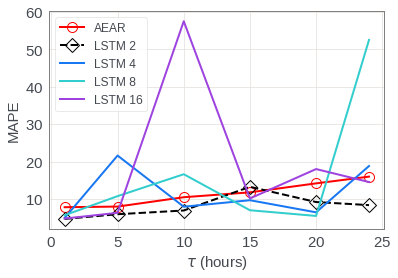

In [57]:
maxe = pd.DataFrame({'tau': tau_hour_values,
    'AEAR': [7.83, 8, 10.5, 11.8, 14.2, 16], 
    'LSTM 2': [4.702796, 5.956416, 6.950138, 13.280911, 9.215275, 8.388519,],
    'LSTM 4': [4.961679, 21.63115, 7.962872, 9.697181, 6.462588, 18.834944,],
    'LSTM 8': [5.69364, 10.78798, 16.642772, 7.022196, 5.498335, 52.523843,],
    'LSTM 16': [ 4.797669, 6.330947, 57.51606, 10.167747, 18.022611, 14.552869, ],
    })
axes = maxe.plot(x='tau', style=['ro-', 'kD--'], fillstyle='none', markersize=10, linewidth=2)
# axes.set_ylim([0, 25])
axes.set_ylabel('MAPE')
axes.set_xlabel(r'$\tau$' + ' (hours)')
# axes.legend(loc='center right', prop={'size': 16})
axes.legend( prop={'size': 12})

color_name = "grey"
axes.spines["top"].set_color(color_name)
axes.spines["bottom"].set_color(color_name)
axes.spines["left"].set_color(color_name)
axes.spines["right"].set_color(color_name)

plt.savefig('mape_tau_aear_lstm.eps', format='eps', bbox_inches="tight", edgecolor='k')


In [64]:
X_train_tensors_final.shape

torch.Size([2200, 1, 74])

In [72]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes  # number of classes
        self.num_layers = num_layers  # number of layers
        self.input_size = input_size  # input size
        self.hidden_size = hidden_size  # hidden state
        self.seq_length = seq_length  # sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        print('lstm output', hn)
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        print('reshaped lstm output', hn)
        out = self.relu(hn)
        print('relu output', out)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out


In [73]:
lstm_sm_rain = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) 
outputs = lstm_sm_rain.forward(X_train_tensors_final) #forward pass
optimizer.zero_grad() #caluclate the gradient, manually setting to 0

# obtain the loss function
loss = criterion(outputs, y_train_tensors)
 

lstm output tensor([[[-0.0274653472,  0.1901232749,  0.1219586954,  ...,
           0.1678119600, -0.0594983809, -0.1537463367],
         [-0.0274653472,  0.1901232749,  0.1219586954,  ...,
           0.1678119600, -0.0594983809, -0.1537463367],
         [-0.0274653472,  0.1901232749,  0.1219586954,  ...,
           0.1678119600, -0.0594983809, -0.1537463367],
         ...,
         [ 0.0222776346,  0.0872956961, -0.0754541606,  ...,
           0.0663974509,  0.0398715436, -0.0352845415],
         [ 0.0222712848,  0.0873068795, -0.0754449591,  ...,
           0.0664141327,  0.0398622006, -0.0352964774],
         [ 0.0222650114,  0.0873179212, -0.0754358694,  ...,
           0.0664306134,  0.0398529582, -0.0353082828]]],
       grad_fn=<StackBackward0>)
reshaped lstm output tensor([[-0.0274653472,  0.1901232749,  0.1219586954,  ...,
          0.1678119600, -0.0594983809, -0.1537463367],
        [-0.0274653472,  0.1901232749,  0.1219586954,  ...,
          0.1678119600, -0.0594983809, -0